# 영화리뷰 텍스트 감성분석하기

## 1) 데이터 준비와 확인

In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2) 데이터로더 구성   

    데이터의 중복 제거
    NaN 결측치 제거
    한국어 토크나이저로 토큰화
    불용어(Stopwords) 제거
    사전word_to_index 구성
    텍스트 스트링을 사전 인덱스 스트링으로 변환
    X_train, y_train, X_test, y_test, word_to_index 리턴



In [2]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    # [[YOUR CODE]]
    train_data.drop_duplicates(subset=['document'], inplace=True) #중복제거
    train_data = train_data.dropna(how = 'any') #제거로 인한 빈칸 지우기
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = [] 
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화 : 문장을 분리시켜줌.
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist() #행렬 연결
    counter = Counter(words)
    counter = counter.most_common(10000-4) #10000개 단어를 쌓는데 아래 4개 자리를 비우기 위해 -4
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):#워드리스트에서 워드를 숫자로 변화시켜주는것.
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))#데이터 리스트 지정
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
#위에서 만든 함수를 아래 데이터 형태로 쪼개줌
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
#load_data를 쪼겐 것

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 모델구성을 위한 데이터 분석 및 가공   

    데이터셋 내 문장 길이 분포
    적절한 최대 문장 길이 지정
    keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가


In [5]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens) #수정 가능한 하이퍼파라미터
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [6]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## 4) 모델구성 및 validation set 구성 

In [7]:
#vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
#word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

#model = keras.Sequential()
#model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
#model.add(keras.layers.Conv1D(16, 7, activation='relu'))
#model.add(keras.layers.MaxPooling1D(5))
#model.add(keras.layers.Conv1D(16, 7, activation='relu'))
#model.add(keras.layers.GlobalMaxPooling1D())
#model.add(keras.layers.Dense(8, activation='relu'))
#model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

#model.summary()

In [8]:
#vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
#word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

#model = keras.Sequential()
#model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
#model.add(keras.layers.GlobalMaxPooling1D())
#model.add(keras.layers.Dense(8, activation='relu'))
#model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

#model.summary()

In [9]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)


model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(32))   # 벡터의 차원수 변경가능
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                6272      
_________________________________________________________________
dense (Dense)                (None, 8)                 264       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 166,545
Trainable params: 166,545
Non-trainable params: 0
_________________________________________________________________


## 5) 모델 훈련 개시

In [10]:
x_val = X_train[:10000]   
y_val = y_train[:10000]


partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [11]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 7s 28ms/step - loss: 0.5555 - accuracy: 0.6877 - val_loss: 0.3711 - val_accuracy: 0.8400
Epoch 2/5
266/266 [==============================] - 7s 27ms/step - loss: 0.3499 - accuracy: 0.8497 - val_loss: 0.3510 - val_accuracy: 0.8474
Epoch 3/5
266/266 [==============================] - 7s 27ms/step - loss: 0.3210 - accuracy: 0.8627 - val_loss: 0.3424 - val_accuracy: 0.8500
Epoch 4/5
266/266 [==============================] - 7s 28ms/step - loss: 0.3078 - accuracy: 0.8686 - val_loss: 0.3549 - val_accuracy: 0.8450
Epoch 5/5
266/266 [==============================] - 7s 27ms/step - loss: 0.2967 - accuracy: 0.8723 - val_loss: 0.3542 - val_accuracy: 0.8508


1. Cov1D model 변경 후 InvalidArgumentError 발생 ---> vocab_size를 10000으로 word_vector_dim는 16으로 변경 후 해결

In [12]:
results = model.evaluate(X_test,  y_test, verbose=2) #테스트셋 평가

print(results)

1537/1537 - 4s - loss: 0.3643 - accuracy: 0.8458
[0.3643185794353485, 0.8457798361778259]


## 6) Loss, Accuracy 그래프 시각화

In [13]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


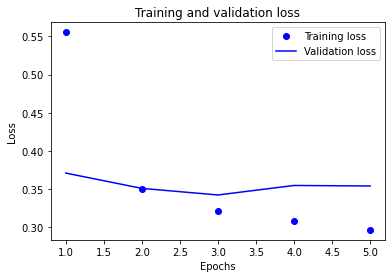

In [14]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

위 그래프에서는 epoch4에서 부터 꺾이는것을 확인할 수 있다.
최적모델 2.0      오버피팅 4.0<

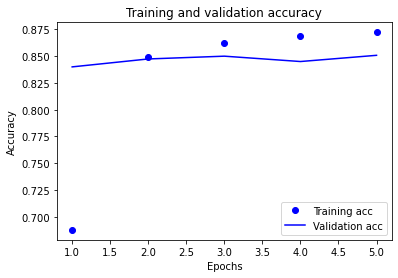

In [15]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 7) 학습된 Embedding 레이어 분석

In [16]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [17]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [18]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['강아지']
vector

array([-2.7569463e-02,  3.9313700e-02, -3.5960596e-02, -8.2595600e-03,
       -7.7715330e-03,  7.9374900e-03, -3.5735901e-02,  6.9624230e-02,
        8.3338411e-05, -3.9630078e-02,  1.6530069e-02, -2.5103694e-02,
        2.4544267e-02,  3.0152176e-03, -6.6395923e-03, -1.6331188e-02],
      dtype=float32)

In [19]:
word_vectors.similar_by_word("감정")

[('잊혀', 0.9421695470809937),
 ('매즈', 0.940902590751648),
 ('꼽힐', 0.9392653703689575),
 ('정규', 0.9307907819747925),
 ('찰스', 0.9283065795898438),
 ('오버랩', 0.9259291291236877),
 ('세라', 0.9227221012115479),
 ('지만은', 0.9174057245254517),
 ('울림', 0.9165482521057129),
 ('감회', 0.9161690473556519)]

1. 사람 : 원한다면, 당신, 개봉관, 유대인, 걱정, 달성, 다른, 보통, 바란다, 상평
2. 짐승 : 명성, 잔다, 클, 우물, 돌연변이, 표면, 루즈, 반감, 미인, 피해자
3. 감정 : 사후, 꾸미, 봐도, 상류층, .^^', 한몫, 꼽히, 기뻤, 장수, 보냅니다.

뭔가 좀 잘 형성되지 않은것같다.

## 8) 한국어 Word2Vec 임베딩 활용하여 성능개선

In [20]:
#from gensim.models import KeyedVectors

#word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)

from gensim import models
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko/ko.bin'
ko_model = models.Word2Vec.load(word2vec_path)
vector = ko_model['강아지']
vector     



/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([ 0.28099054, -0.19049376,  0.31788886, -0.29404902, -0.6012117 ,
       -0.25619242,  0.0061479 ,  0.51780385,  0.3608627 , -0.27890292,
        0.3753059 ,  0.45682365,  0.25841945,  0.29509434,  0.31509322,
        0.53255475, -0.3150408 ,  0.28672394,  0.32292762, -0.11534653,
        0.24962434, -0.31804952,  0.02379435,  0.34782323, -0.5428502 ,
       -0.31428298,  0.81061304,  0.7245631 ,  0.04309795, -1.0204421 ,
        0.10398801,  0.2138965 ,  0.10057439, -0.03146021,  0.0894748 ,
       -0.40986905,  0.11873247,  0.2684793 , -0.6372648 ,  0.36586553,
       -0.15963972,  0.3209763 , -0.6995127 , -1.1059827 ,  0.37646636,
       -0.82615834,  0.12098166, -0.04935855, -0.5623957 ,  0.1068015 ,
        0.2640723 ,  0.6015352 ,  0.31571352, -0.37577182, -0.5941042 ,
        0.1046523 , -0.16794747,  0.36965755,  0.18888052, -0.18799411,
        0.13297085,  0.13900231, -0.25006363, -0.7406368 ,  0.1037019 ,
       -0.18334036, -0.17581826,  0.08528292, -0.07013045,  0.45

1. 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte 오류 발생. ---> 모델 형식 변경 해결.

In [21]:
ko_model.similar_by_word("감정")

/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('욕망', 0.7054284811019897),
 ('편견', 0.6874632835388184),
 ('열등감', 0.667594313621521),
 ('언동', 0.6591923832893372),
 ('성욕', 0.6532760858535767),
 ('감정적', 0.6506438851356506),
 ('불안감', 0.646043062210083),
 ('혐오감', 0.6433851718902588),
 ('인간성', 0.6428232789039612),
 ('정서적', 0.641869306564331)]

1. 사람 : 젊은이, 여인, 백성, 포졸, 죄인, 선비, 부녀자, 죄수, 구경꾼, 손님
2. 짐승 : 천적, 뱀, 괴물, 거미, 곤충, 물고기, 토끼, 진딧물, 배설물, 멧돼지
3. 감정 : 욕망, 편견, 열등감, 언동, 성욕, 감정적, 불안감, 혐오감, 인간성, 정서적

세차례 확인. 임베딩 잘 형성된것으로 보임.

In [22]:
import numpy as np
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 ko-model 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in ko_model:
        embedding_matrix[i] = ko_model[index_to_word[i]]

/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if __name__ == '__main__':
/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


1. ValueError: could not broadcast input array from shape (200) into shape (300)
발생 ----> word_vector_dim 을 200 으로 수정

In [23]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
#model.add(keras.layers.Conv1D(16, 7, activation='relu'))
#model.add(keras.layers.MaxPooling1D(5))
#model.add(keras.layers.Conv1D(16, 7, activation='relu'))
#model.add(keras.layers.GlobalMaxPooling1D())
#model.add(GRU(hidden_size, input_shape=(timesteps, input_dim)))
model.add(keras.layers.LSTM(64))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                67840     
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 2,068,369
Trainable params: 2,068,369
Non-trainable params: 0
_________________________________________________________________


 trainable를 False로 변경

In [24]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 25s 94ms/step - loss: 0.5747 - accuracy: 0.6548 - val_loss: 0.3911 - val_accuracy: 0.8242
Epoch 2/5
266/266 [==============================] - 26s 96ms/step - loss: 0.3498 - accuracy: 0.8485 - val_loss: 0.3312 - val_accuracy: 0.8556
Epoch 3/5
266/266 [==============================] - 26s 97ms/step - loss: 0.2994 - accuracy: 0.8742 - val_loss: 0.3200 - val_accuracy: 0.8617
Epoch 4/5
266/266 [==============================] - 25s 95ms/step - loss: 0.2730 - accuracy: 0.8861 - val_loss: 0.3245 - val_accuracy: 0.8609
Epoch 5/5
266/266 [==============================] - 25s 95ms/step - loss: 0.2497 - accuracy: 0.8970 - val_loss: 0.3318 - val_accuracy: 0.8624


In [25]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 6s - loss: 0.3397 - accuracy: 0.8573
[0.3397454023361206, 0.8573143482208252]


1. 1차시도 LSTM모델 epoch20 80.12 ---> epoch 4로 변경
2. 2차시도 LSTM모델 epoch4  80.78 ---> 모델을 Conv1S로 변경
3. 3차시도 Cov1D모델 epoch4  80.38 --->  trainable를 False로 변경
4. 4차시도 Cov1D모델 epoch4 73.86 ----> ko.bin을 다시 다운로드
5. 5차시도 Cov1D모델 epoch4 74.18 ----> GlobalMaxPooling1D로 모델 변경
6. 6차시도 GlobalMaxPooling1D epoch4 73.46 ---> val set과 partial train set 재분배, trainable를 True로 변경, Model LSTM(128)으로 변경, epoch5로 변경
7. 7차시도 LSTM(128) epoch5 86.4
8. 8차시도 LSTM(8) epoch5 84.81
9. 9차시도 Cov1D epoch5 84.7
10. 10차시도 Cov1D epoch10 83.97
11. 11차시도 Cov1D epoch10 84.62
12. 12차시도 GlobalMaxPooling1D epoch20 82.83
13. 13차시도 LSTM(32) epoch10 85.52
14. 14차시도 LSTM(32) epoch5 85.59   
GRU model

In [26]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


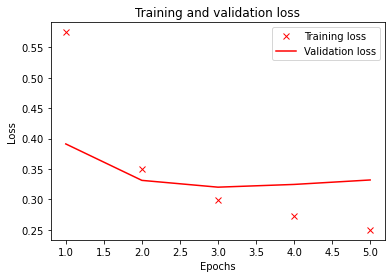

In [27]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, 'rx', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

트레인 셋을 통하여 학습을 진행할수록 loss값은 낮아진다. 벨류데이션 loss값 또한 낮아지게 되는데 이게 꺾여서 올라가는 순간부터 오버피팅이 시작된다 보고 두 그래프의 사이가 점점 멀어지며 좋지 않은 모델이 형성된다. 때문에 좋은 모델을 사용하기 위해서는 그래프가 꺾이는 순간이 가장 좋은 모델이다.

위 그래프에서는 epoch3에서 꺾여 올라가는것을 확인할수있다.
최적모델 2.0  오버피팅 3<

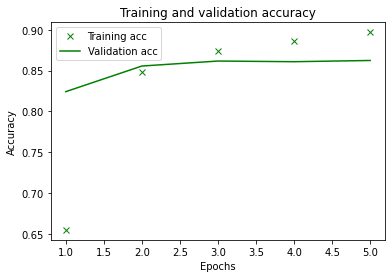

In [28]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'gx', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 느낀점
지금까지 진행한 노드중에서 가장 어려웠고 가장 지치는 노드였다. 처음 시작할때 데이터 전처리에서 뇌정지가 왔다. 거기에서부터 머리가 멈춰버리니 그 뒷 내용을 기존 노드를 참고하여 진행할 생각도 못했다. 눈으로 읽고 있는 노드와 진행할 부분이 전혀 매치가 되지 않았고 갑자기 이렇게 난이도가 올라간다고? 앞으로 어떻게 따라가지? 등 오만생각이 다 나며 갈피를 못잡고 있었다. 그렇게 맨탈이 나간 상태로 제출기한을 얼마 안남겼을때 처음 전처리 부분이 나타내는 의미를 간략하게 설명을 들으며 나갔던 맨탈을 조금 돌리고 뒤쪽 내용을 진행하게 되었다. 그러나 코드 내용이 이해가 되는것은 아니었다. 그저 복사 붙여넣기로 꾸역꾸역 진행만 시켰고 한글 임베딩 모델적용에서는 또 한참을 고민하고 찾아보다가 결국 스스로 해결하지 못하고 도움을 받았다. 마지막 결과 accuracy도 마찬가지다. 스스로 수차례 시도해 보았을때 도저히 80위로 넘길수가 없었고 이때도 도움을 받아 문제를 해결했다. 이처럼 많은 도움을 받아가며 진행을 하였는데 혼자 문제 해결을 위해 구글링을 시도하지 않은 것은 아니었다. 단지 막상 필요한 부분이 적혀있는 블로그 등 게시물을 찾아놓고도 적용을 못하는 '낫놓고 기역자도 모른다'가 딱 나의 모습이었다.

그래도 한가지 배운게 있다면 그래프를 해석할 때 노드상에서는 트레인셋과 벨류셋간의 간격이 벌어진다고 설명되어 있는것을 잘못이해하고 있었는데 옳은 해석은 각격이 벌어진다기 보다는 한쪽이 진행방향이 달라지는 순간부터 벌어지는것을 의미하는것을 알게 되었다. 그것을 이용하여 좋은 모델을 선정하고 그에 맞춰 epoch값을 조정하여 좋은 accuracy를 얻는 시도를 해볼 수 있었다. 

사실 앞선 E1, 2, 3 을 수행하던 때 처럼 시간을 들여 좀 더 한줄한줄 뜯어보며 이해하고 실행 코드중 중복되거나 불필요한 부분을 다듬으며 난잡한 코드를 나름 정리를 해보거나 조금 더 여러 파라메터를 조정하여 다양한 값을 뽑아보고 싶었지만 진행하지 못한게 아쉽다. 불용단어도 바꿔보고, 데이터셋도 다시 나눠보는 등 바꿀수 있는 수치가 많음에도 불구하고 한정된 수치만 변경하여 값을 도출한것도 그렇고 여러가지로 부족함을 느낀 노드 수행이었다.